# DTW-SOM Evaluation - experiment with the GunPoint dataset

## 1. Packadge import

In [4]:
import os
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
from pyclustering.nnet.som import type_conn
from matrixprofile import matrixProfile, motifs
# local code
import sys
sys.path.insert(0, os.path.abspath('../src'))
import dtwsom

## 2. Preprare the CricketZ dataset

Load the dataset:

In [2]:
ucr_data_folder = os.path.abspath("../../data-ucr-archive")
file = os.path.join(ucr_data_folder, "CricketZ", "CricketZ_TRAIN.tsv")
ts_data = []
ts_labels = []
with open(file) as tsvfile:
    tsvreader = csv.reader(tsvfile, delimiter="\t", quoting=csv.QUOTE_NONNUMERIC)
    for line in tsvreader:
        ts_labels.append(line[0])
        ts_data.append(np.array(line[1:]))
size = len(ts_data[0])
classes = len(set(ts_labels))
print("Subquence size: "+str(size))
print("No of classes: "+str(classes))
print("Dataset size:: "+str(len(ts_labels)))

Subquence size: 300
No of classes: 12
Dataset size:: 390


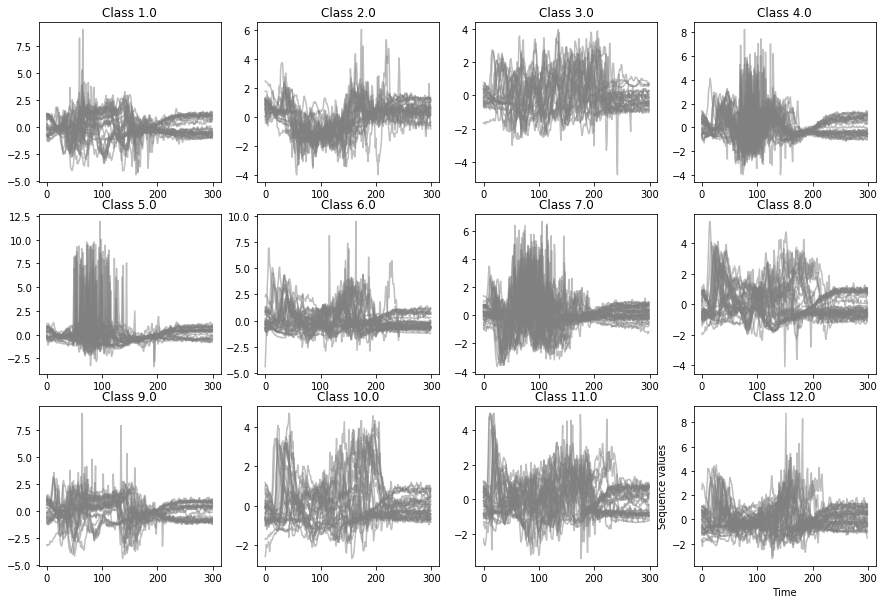

In [20]:
fig, axs = plt.subplots(3, 4, figsize=(15,10))
for i in range(len(ts_labels)):
    label = ts_labels[i]-1
    col = int(label % 4)
    row = math.floor(label/4)
    axs[row, col].plot(np.arange(300), ts_data[i], alpha=0.5, color="grey")
    axs[row, col].set_title("Class "+str(label+1))
plt.ylabel("Sequence values")
plt.xlabel("Time")
plt.show()

Convert it to a single time-series by concatenating each subsequence:

In [21]:
joined_ts_data = ts_data[0]
joined_ts_labels = [ts_labels[0]]*size
for i in range(1, len(ts_labels)):
    joined_ts_data = np.concatenate((joined_ts_data, ts_data[i]))
    joined_ts_labels = joined_ts_labels + [ts_labels[i]]*size
len(joined_ts_data)

117000

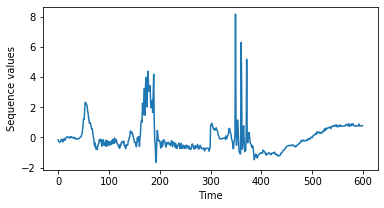

In [23]:
plt.figure(figsize=(6,3))
plt.plot(np.arange(600), joined_ts_data[:600])
plt.ylabel("Sequence values")
plt.xlabel("Time")
plt.show()

Compute the matrix profile with STOMP:

In [24]:
%%time
mp = matrixProfile.stomp(joined_ts_data, size)

CPU times: user 12min 48s, sys: 41.8 s, total: 13min 30s
Wall time: 13min 48s


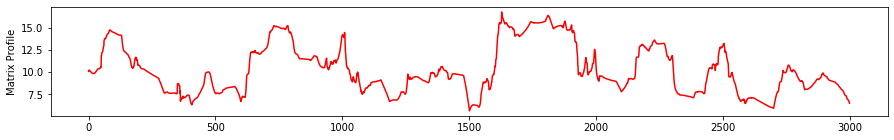

In [25]:
mp_adj = np.append(mp[0],np.zeros(size-1)+np.nan)

plt.figure(figsize=(15,2))
plt.plot(np.arange(3000), mp_adj[:3000], color='red')
plt.ylabel("Matrix Profile")
plt.show()

Extract all the motifs:

In [26]:
%%time
mtfs, motif_d  = motifs.motifs(joined_ts_data, mp, max_motifs=1000)
len(mtfs)

CPU times: user 2.51 s, sys: 111 ms, total: 2.62 s
Wall time: 2.68 s


79

Create list of motifs centers:

In [27]:
motif_center_list = []
motif_center_labels = []
for motif in mtfs:
    center_pointers = list(np.arange(motif[0], motif[0]+size))
    motif_center_ts = joined_ts_data[center_pointers]
    motif_center_list.append(motif_center_ts)
    center_labels = [joined_ts_labels[i] for i in center_pointers]
    center_final_label = max(center_labels, key=center_labels.count)
    motif_center_labels.append(center_final_label)

## 3. DTW-SOM training and results

Define the SOM network:

In [28]:
%time
rows = 4
cols = 4
structure = type_conn.grid_four
network = dtwsom.DtwSom(rows, cols, structure)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


Train the network:

In [29]:
%%time
network.train(motif_center_list, 50)

Epoch 1 achieved an average quantization error of 6.123
Epoch 2 achieved an average quantization error of 5.9394
Epoch 3 achieved an average quantization error of 6.0584
Epoch 4 achieved an average quantization error of 6.0182
Epoch 5 achieved an average quantization error of 5.9877
Epoch 6 achieved an average quantization error of 6.0531
Epoch 7 achieved an average quantization error of 6.0767
Epoch 8 achieved an average quantization error of 6.0904
Epoch 9 achieved an average quantization error of 6.1124
Epoch 10 achieved an average quantization error of 6.0743
Epoch 11 achieved an average quantization error of 6.048
Epoch 12 achieved an average quantization error of 6.0415
Epoch 13 achieved an average quantization error of 6.052
Epoch 14 achieved an average quantization error of 6.0689
Epoch 15 achieved an average quantization error of 6.0954


KeyboardInterrupt: 

Vizualise DTW-SOM U-matrix:

In [ ]:
network.show_distance_matrix()

Vizualise the winner matrix:

In [ ]:
network.show_winner_matrix()

Vizualise the units' sequence values:

In [ ]:
n_neurons = network._size
fig, axs = plt.subplots(3,3,figsize=(8, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/3)
    row = neuron_index % 3
    neuron_weights = network._weights[neuron_index]
    axs[row, col].plot(np.arange(len(neuron_weights)), neuron_weights, label=str(neuron_index))
    axs[row, col].set_title("Unit: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Sequence values")
    if row == 2:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

In [ ]:
true_labels = []
predicted_labels = []
for cluster_list in network.capture_objects:
    cluster_true_labels = [motif_center_labels[i] for i in cluster_list]
    cluster_label = max(cluster_labels, key=cluster_labels.count)
    cluster_predicted_labels = [cluster_label]*len(cluster_labels)
    true_labels += cluster_true_labels
    predicted_labels += cluster_predicted_labels
accuracy = np.mean([i==j for i,j in zip(true_labels, predicted_labels)])
accuracy